## Importing Essential Packages

qwerty

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, losses, metrics

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB  # 如需朴素贝叶斯，取消注释
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

## Dataset Ploting

qwerty

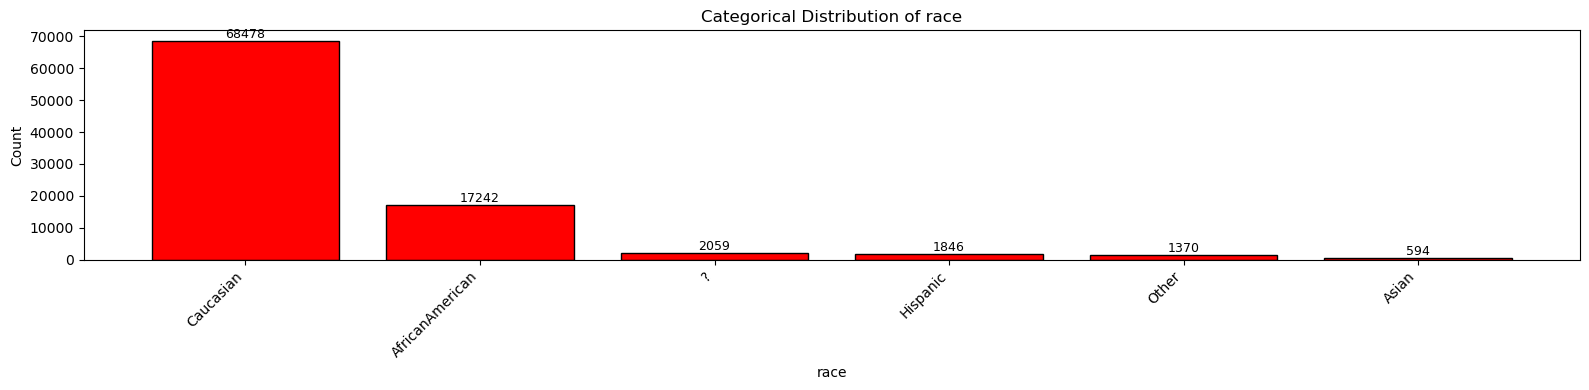

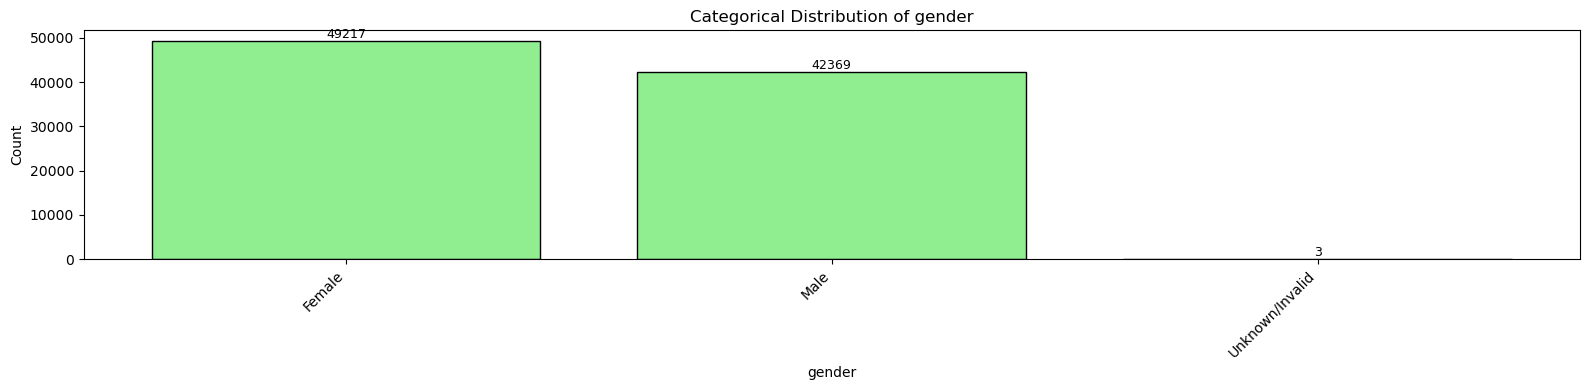

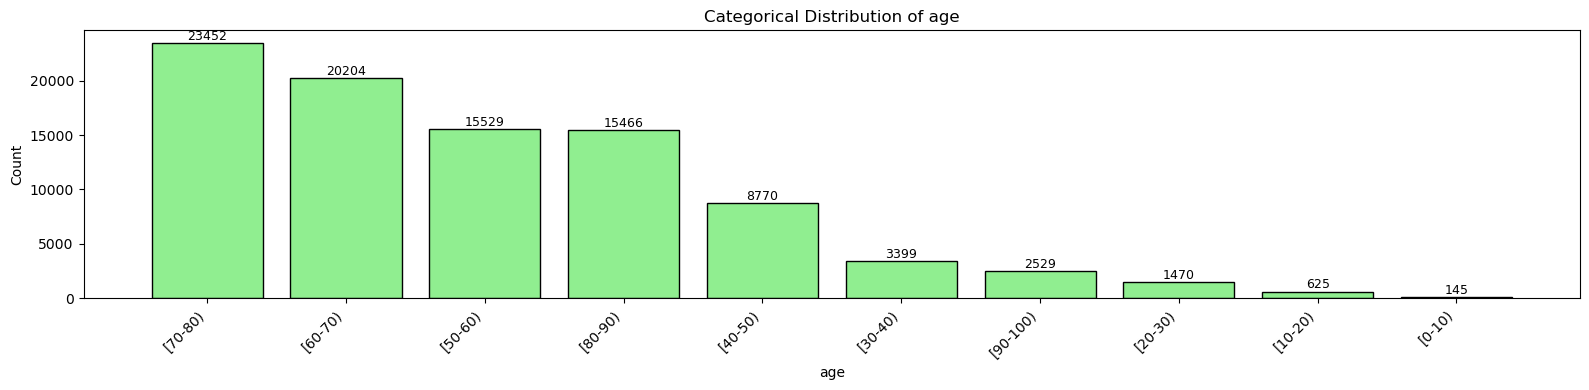

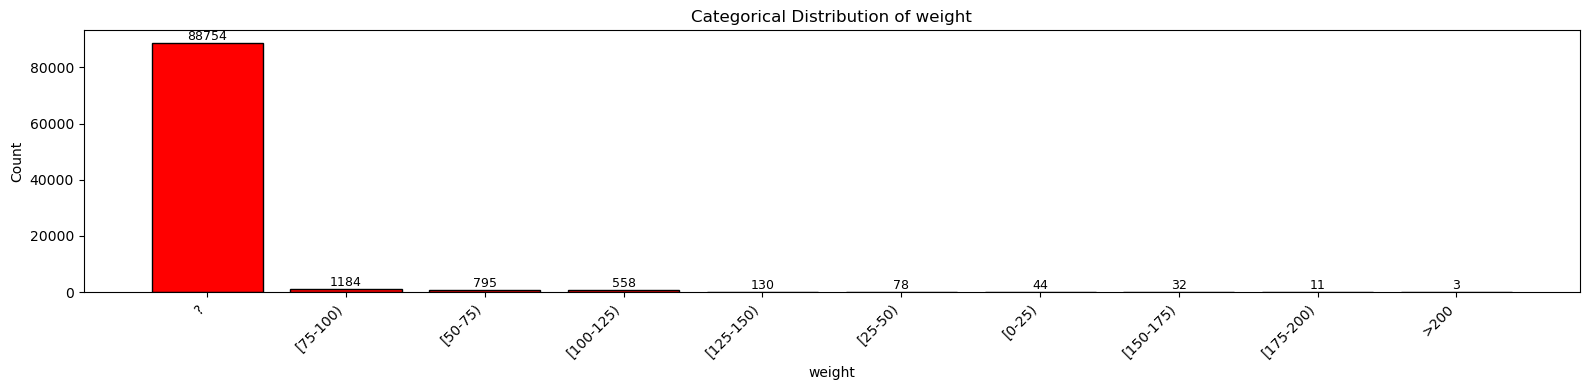

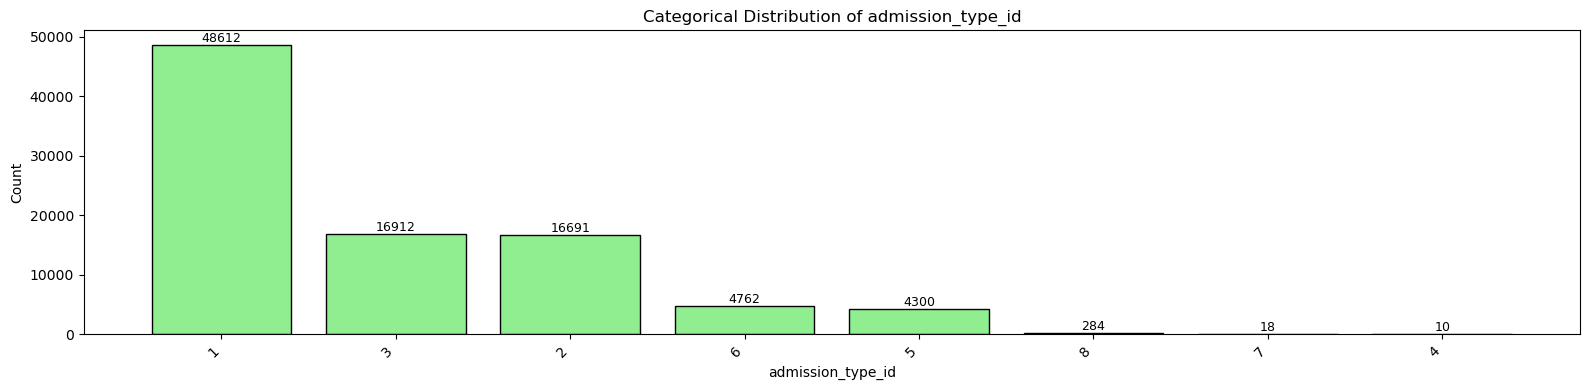

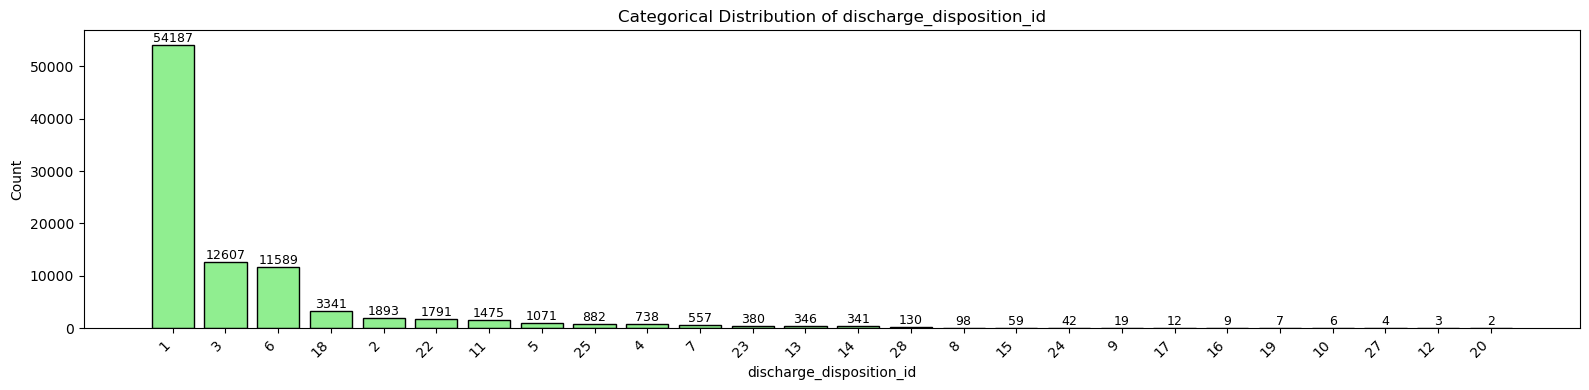

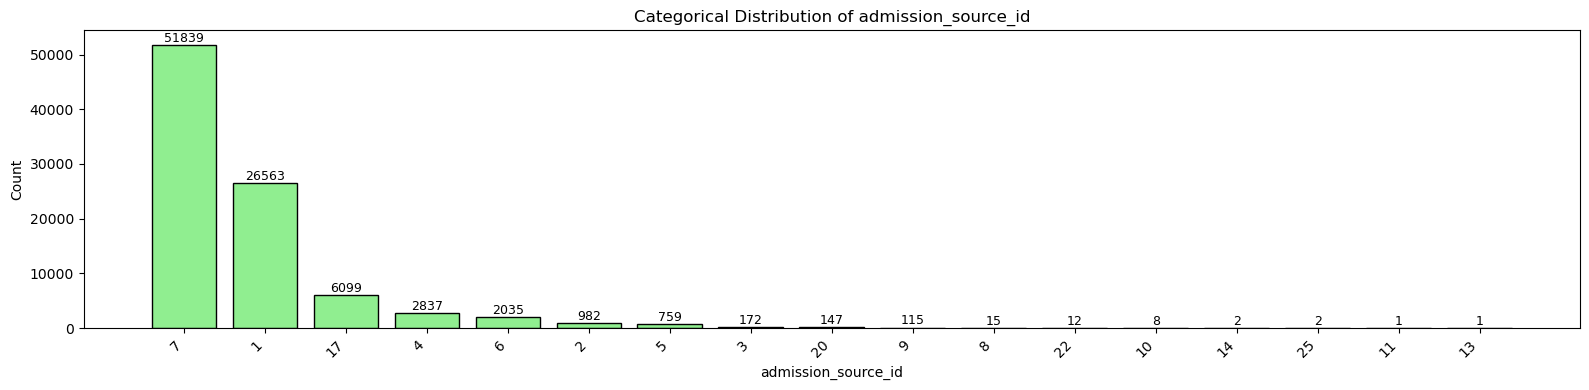

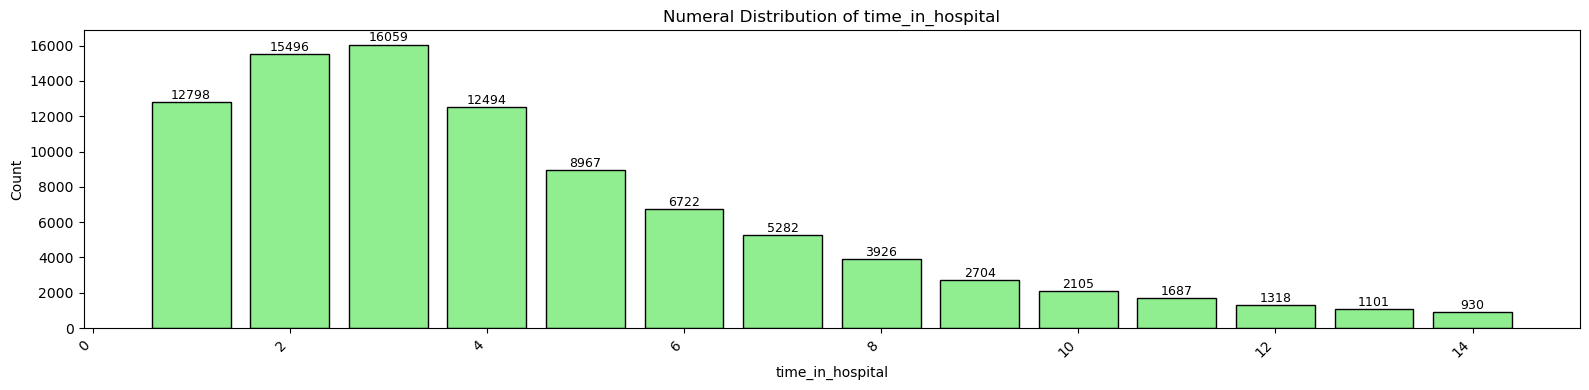

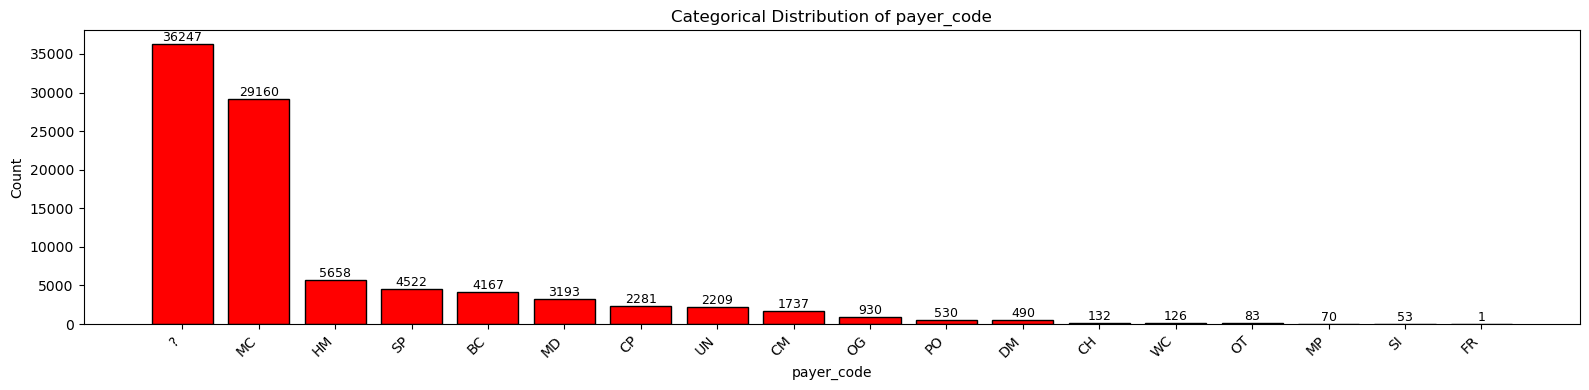

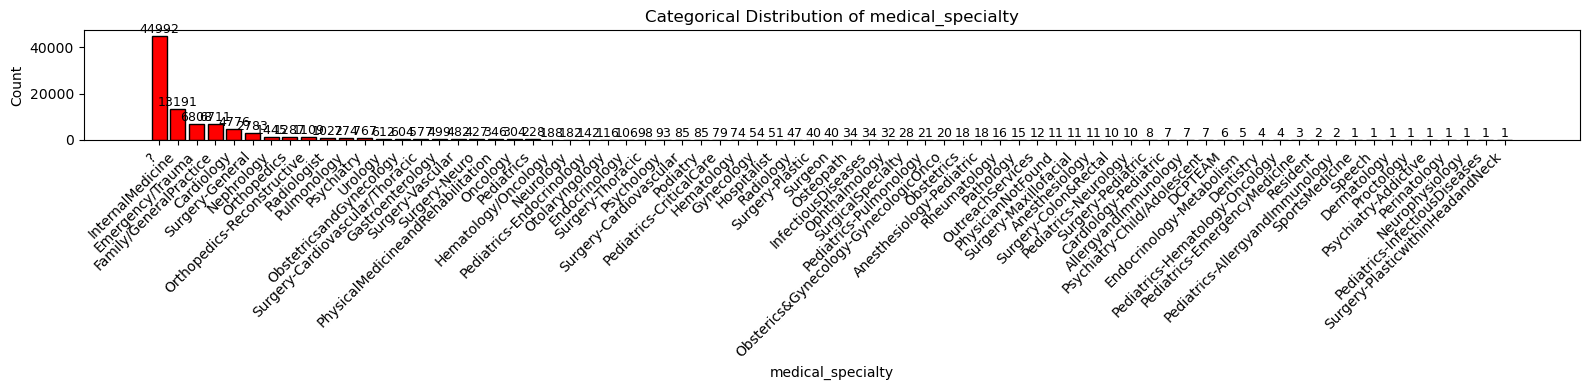

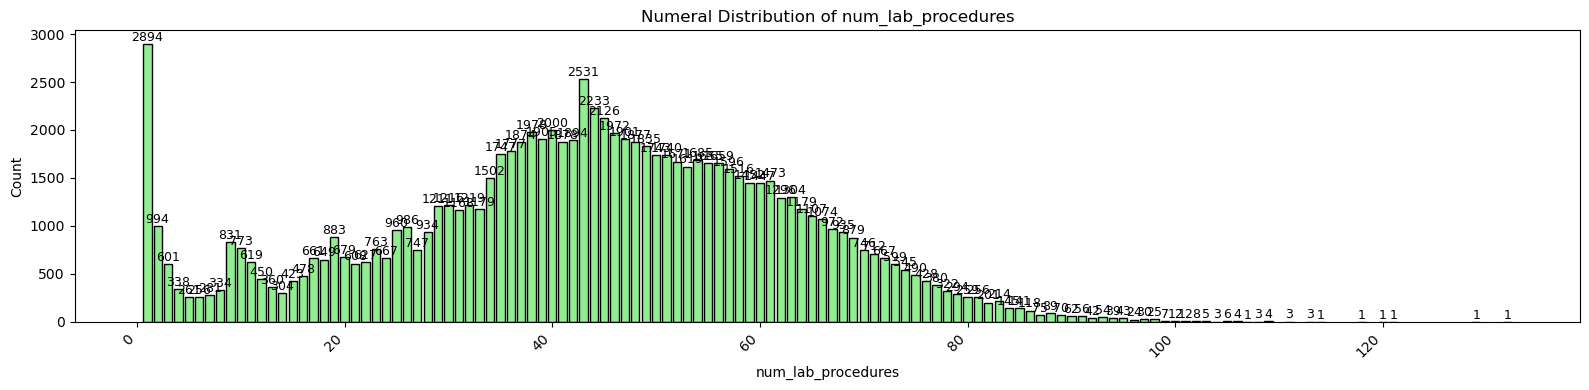

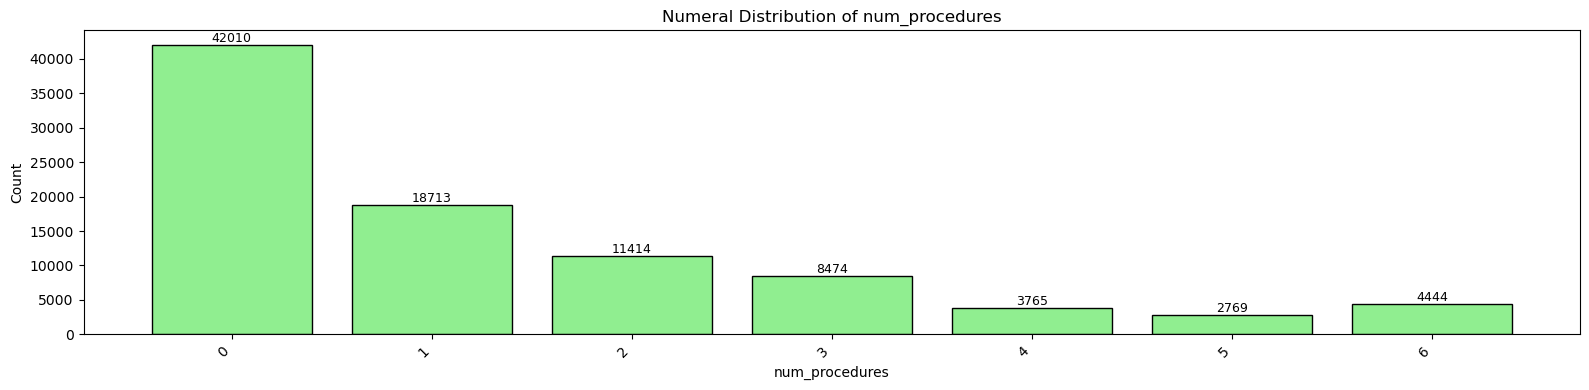

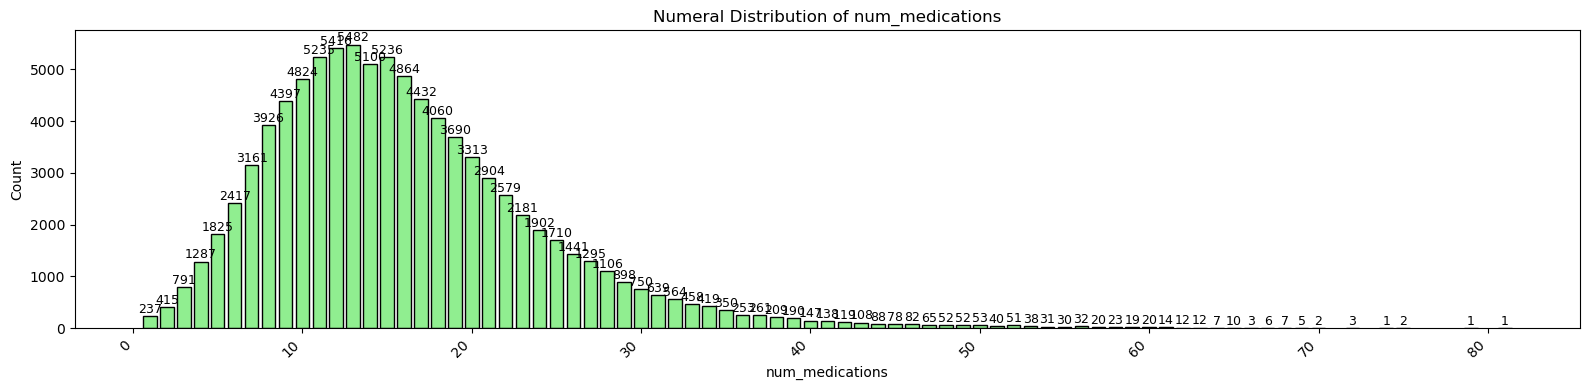

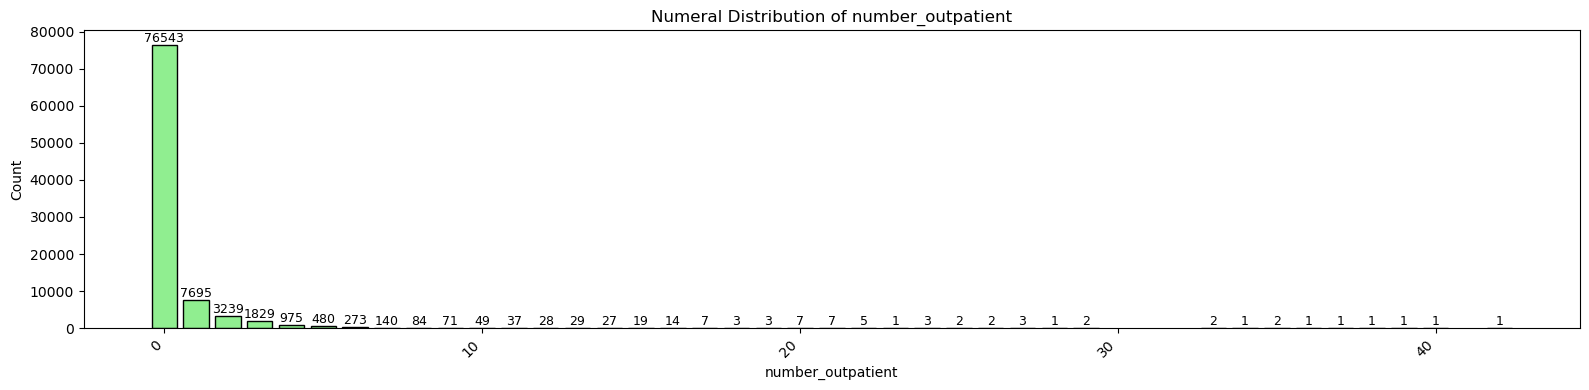

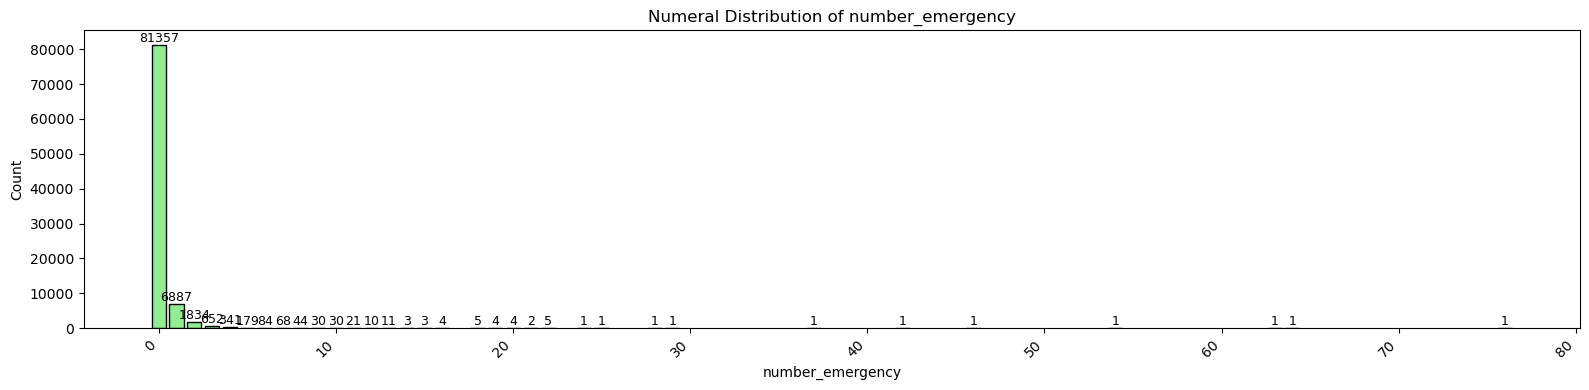

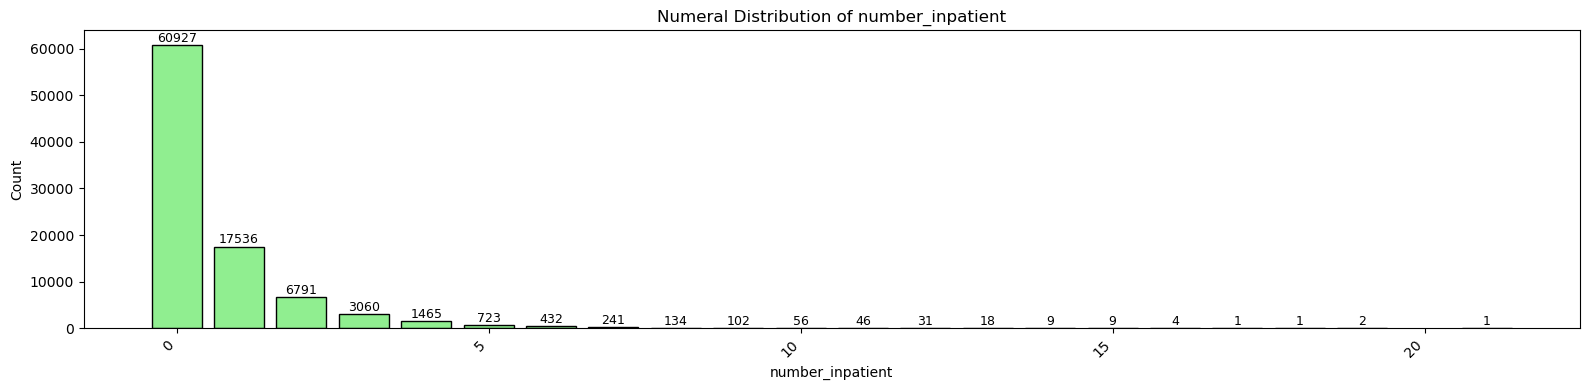

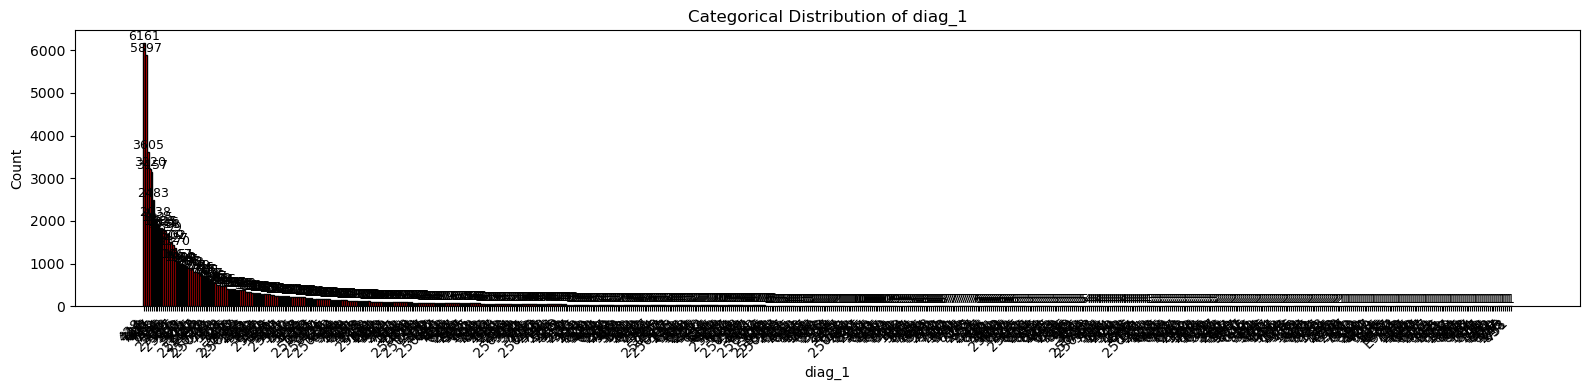

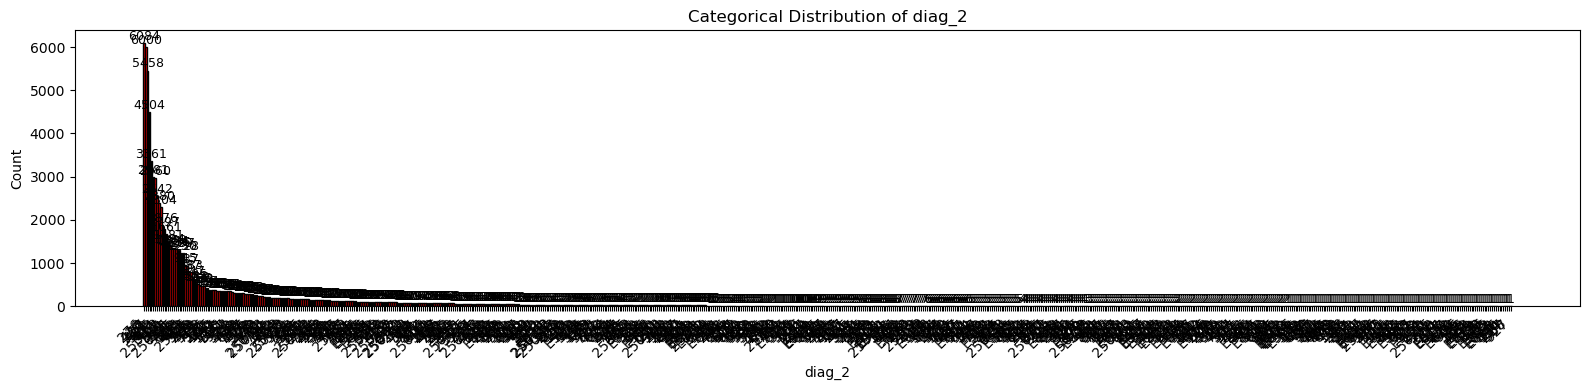

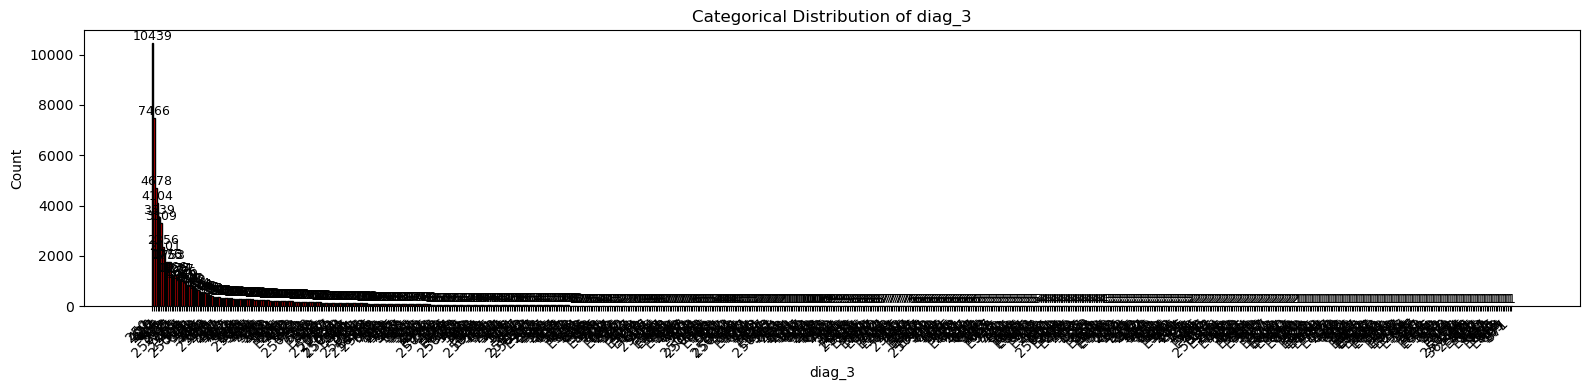

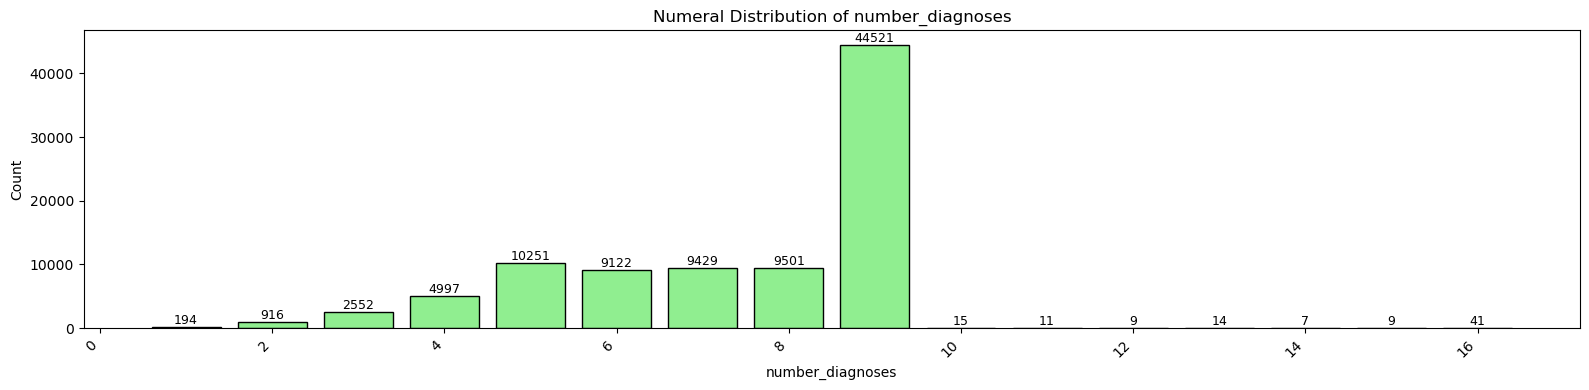

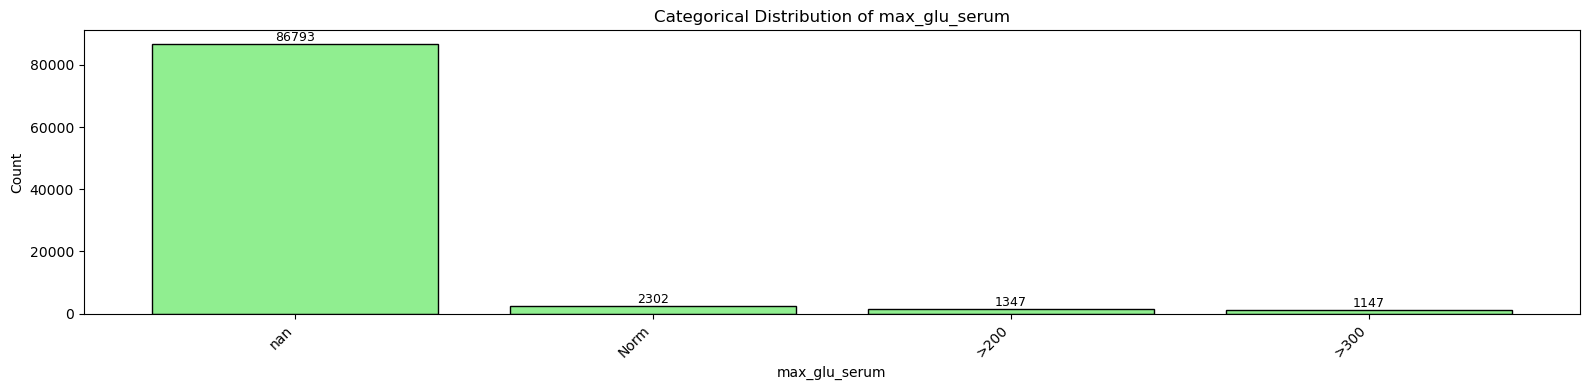

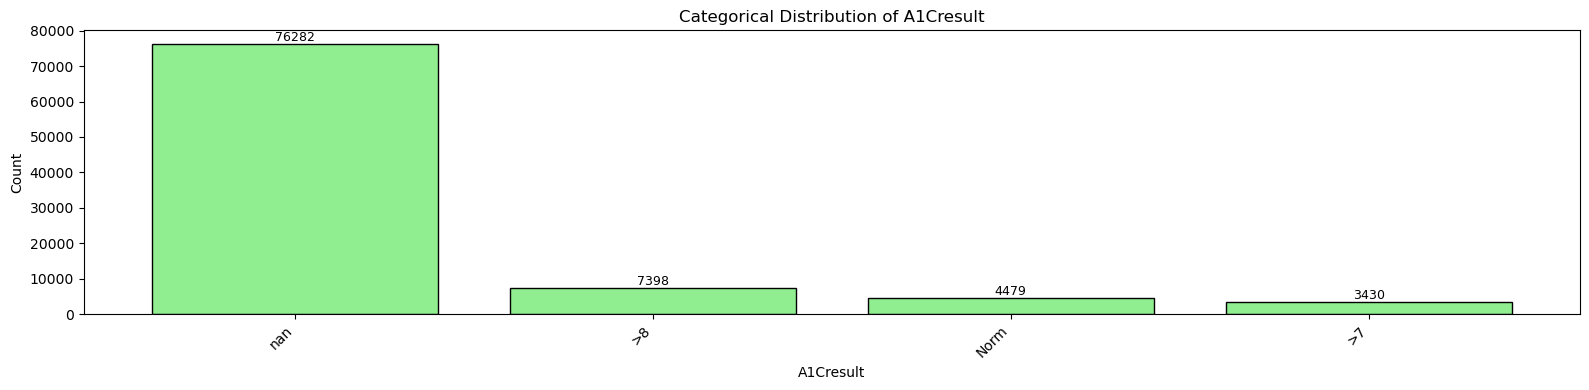

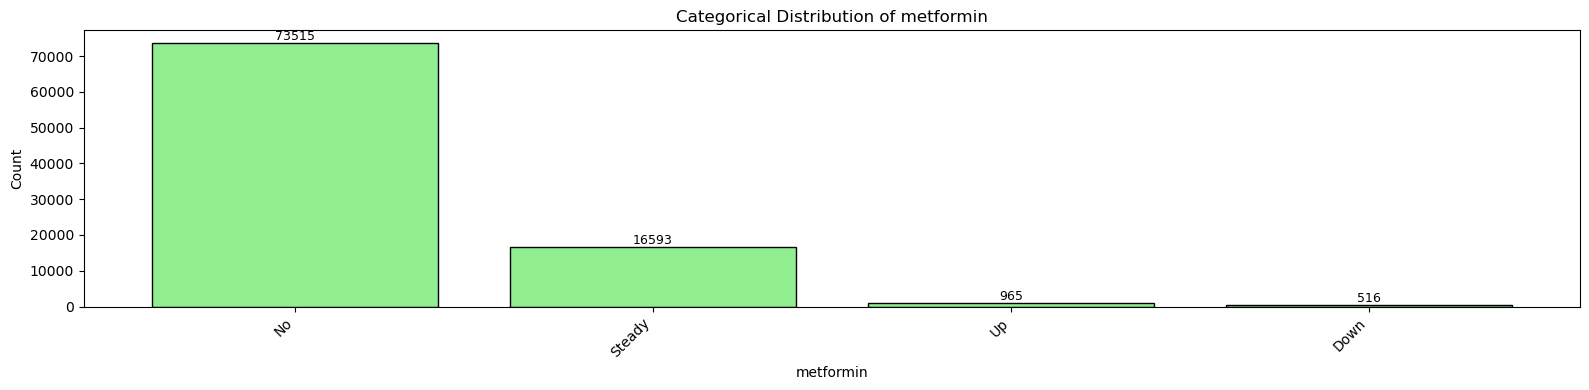

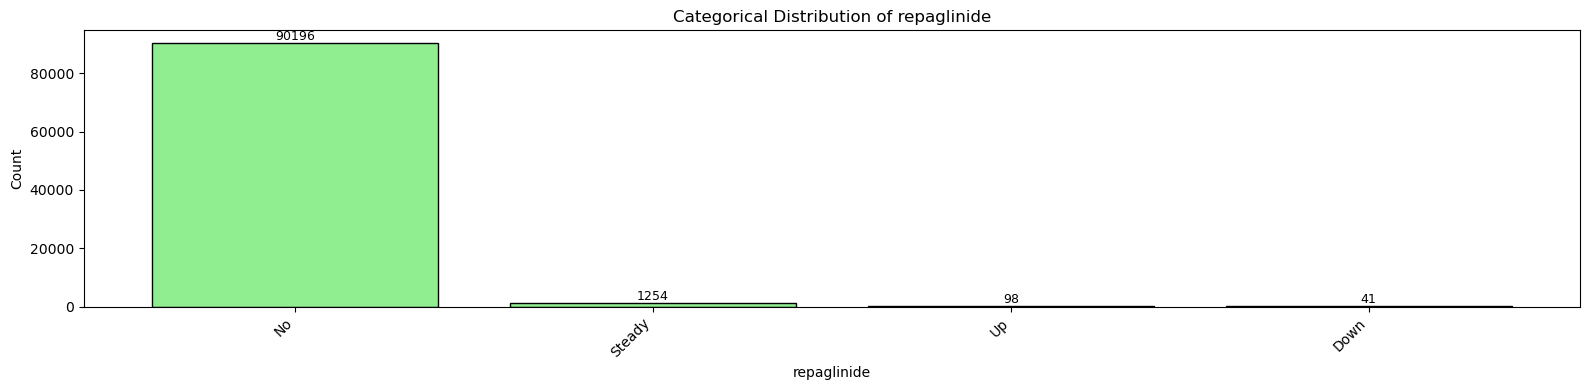

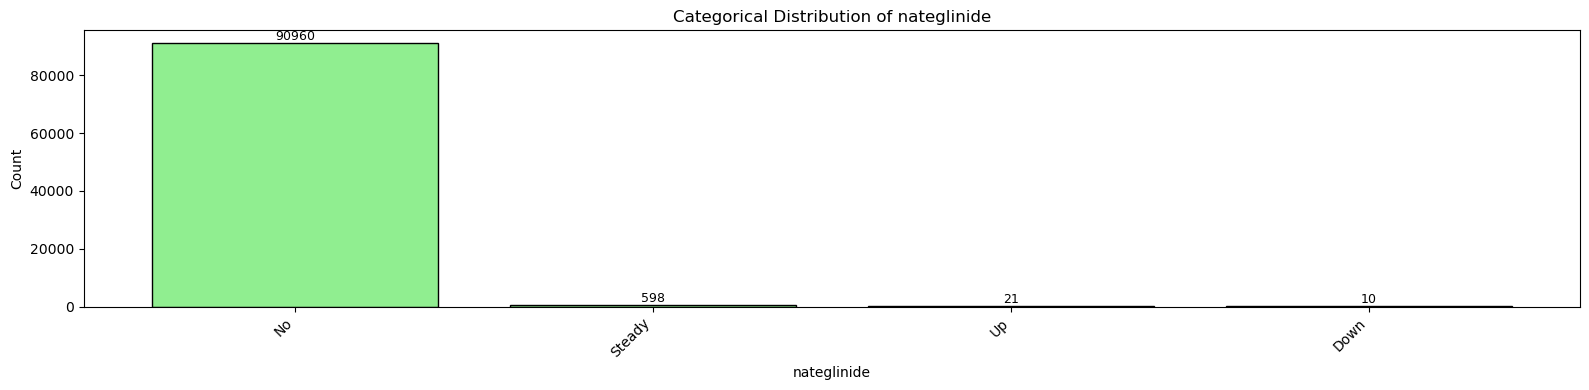

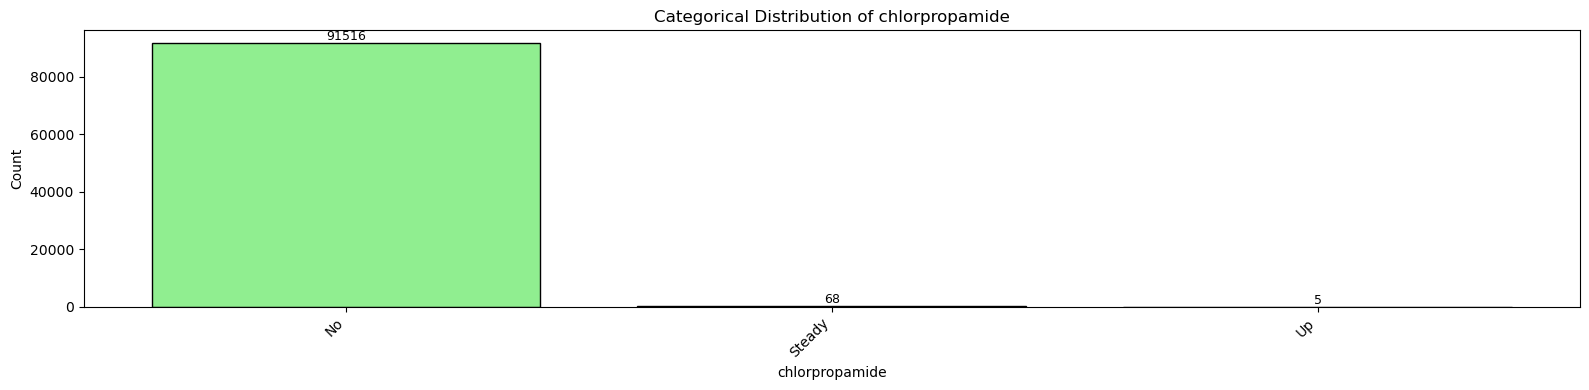

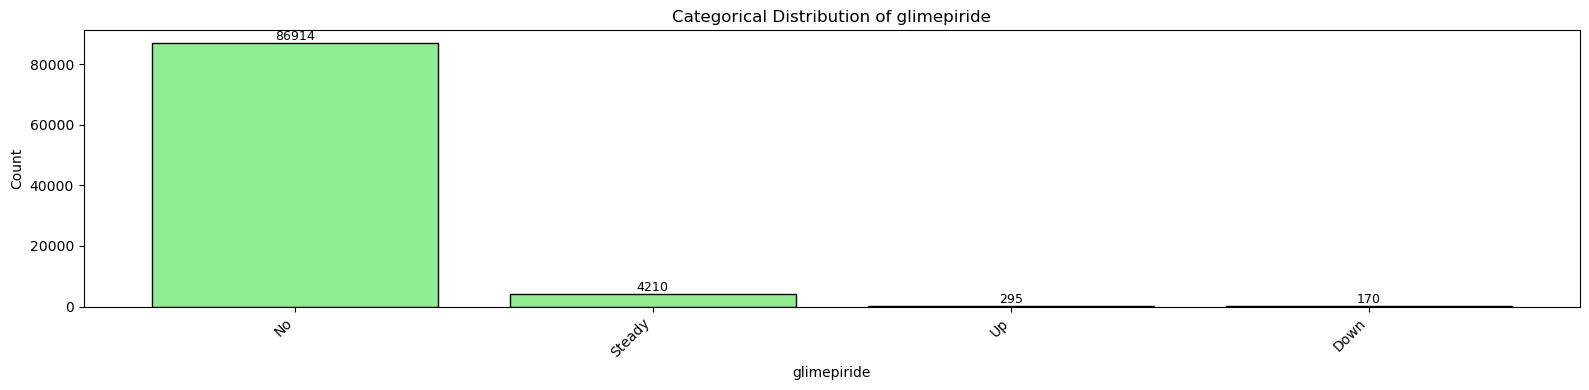

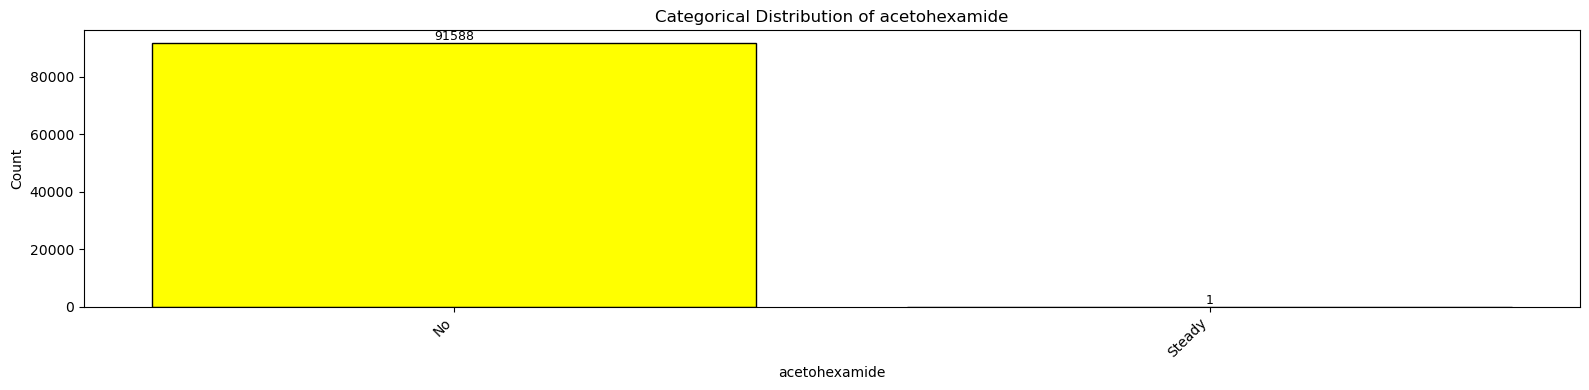

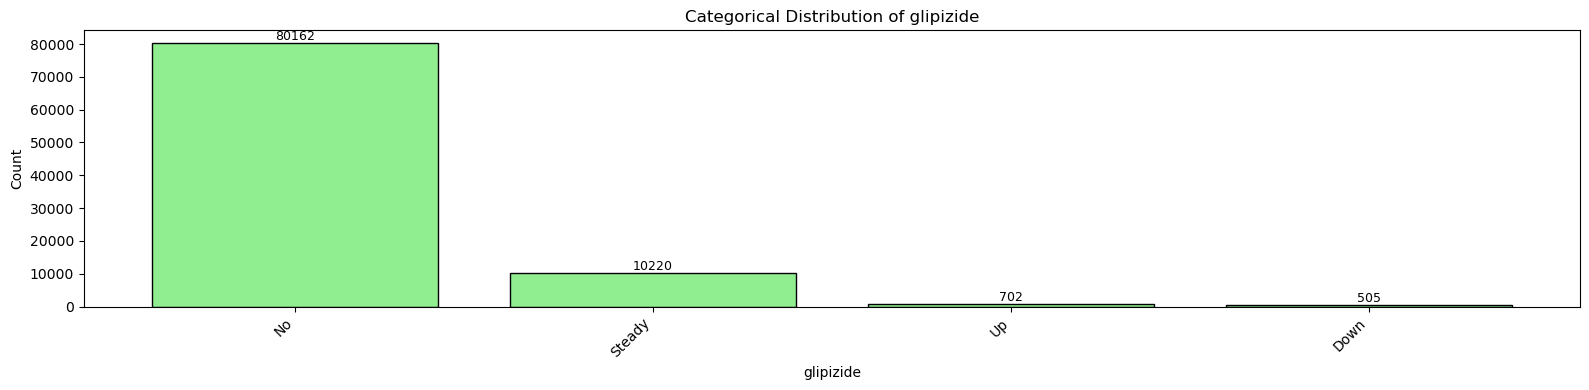

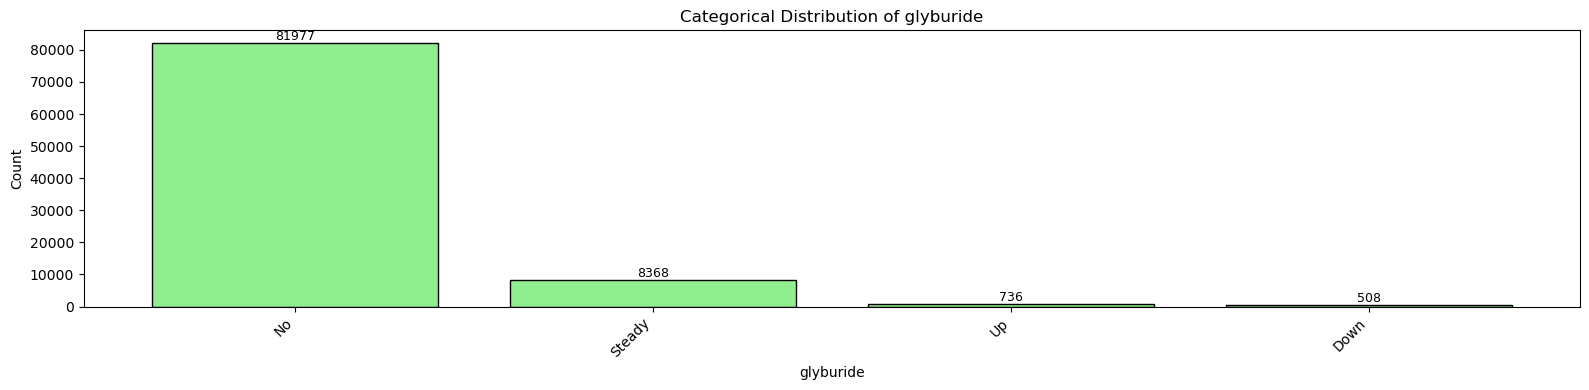

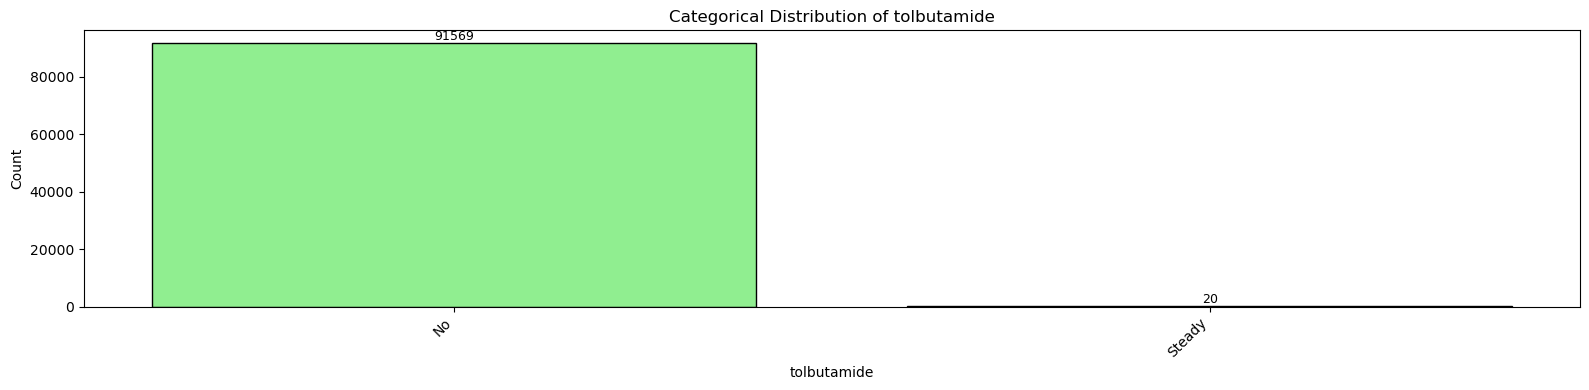

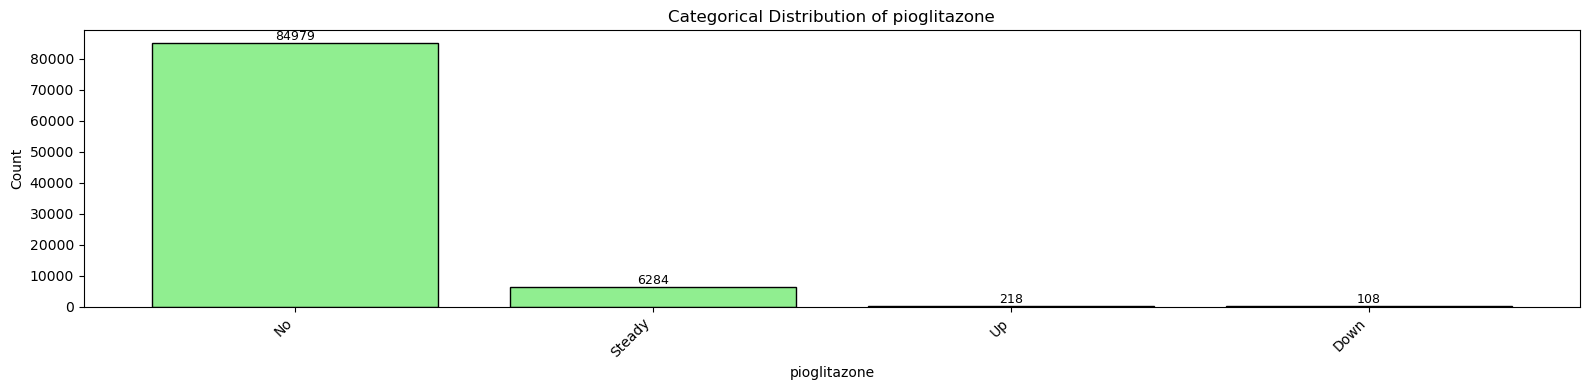

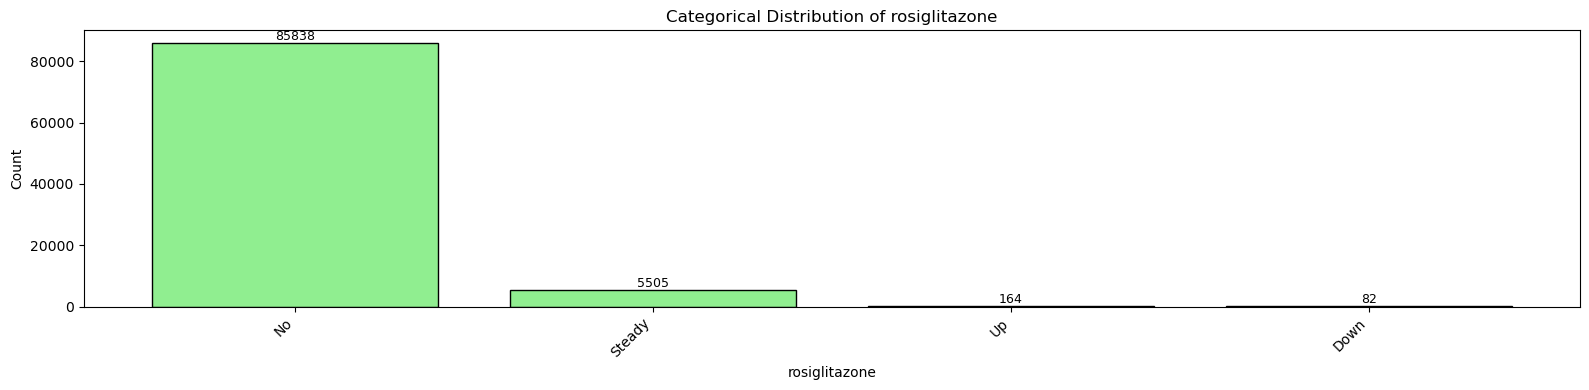

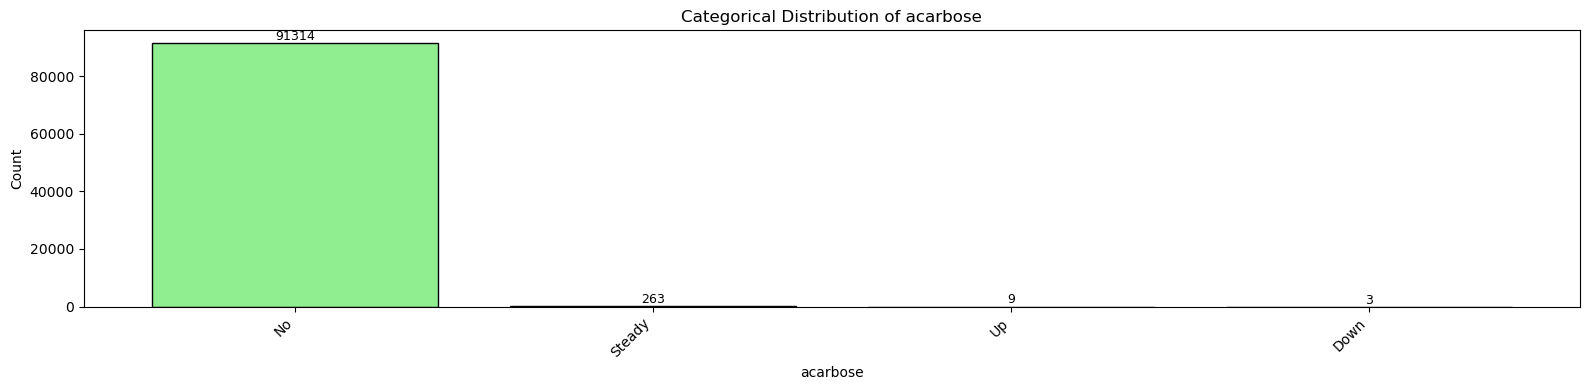

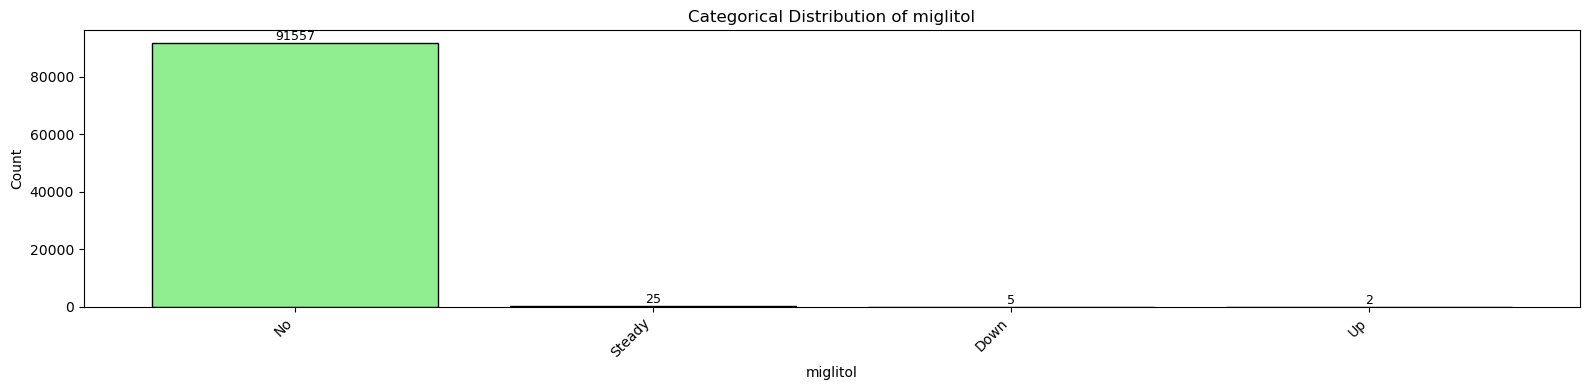

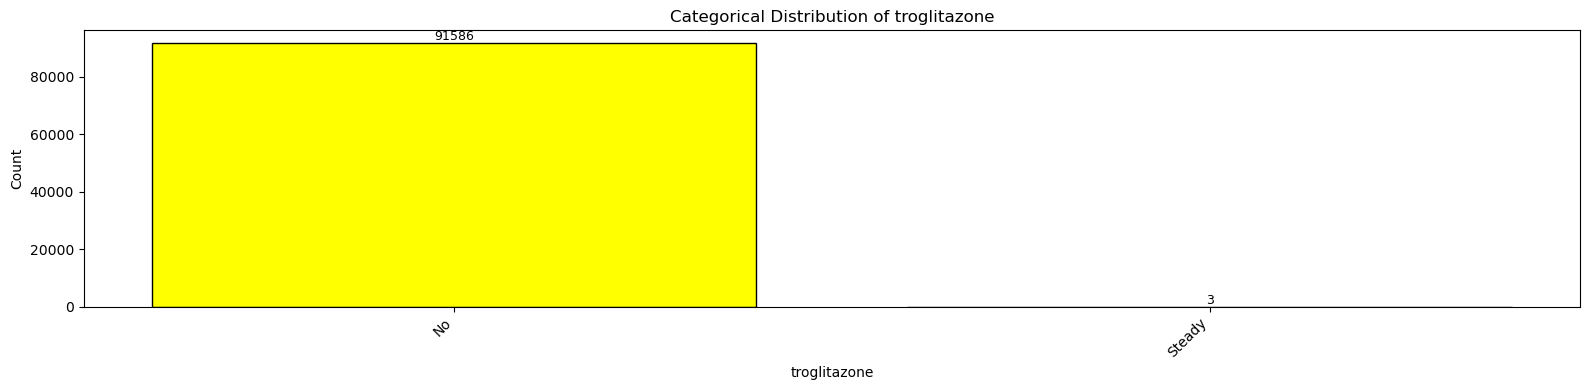

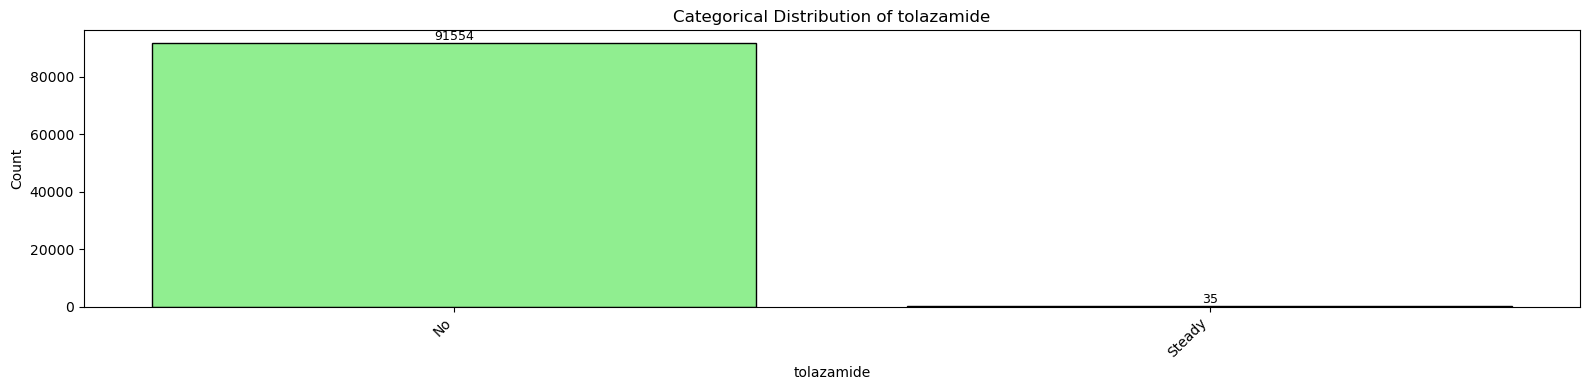

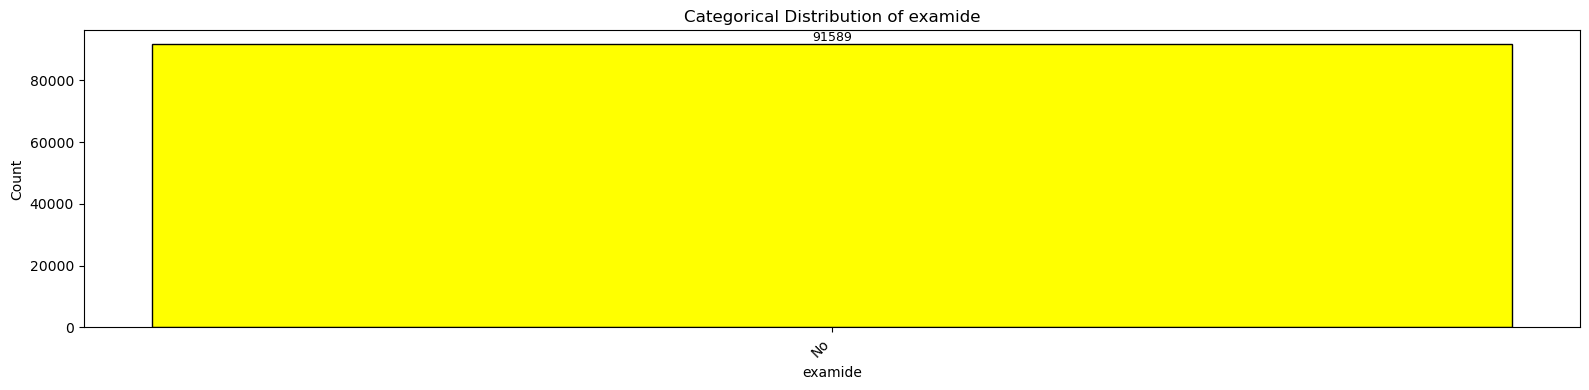

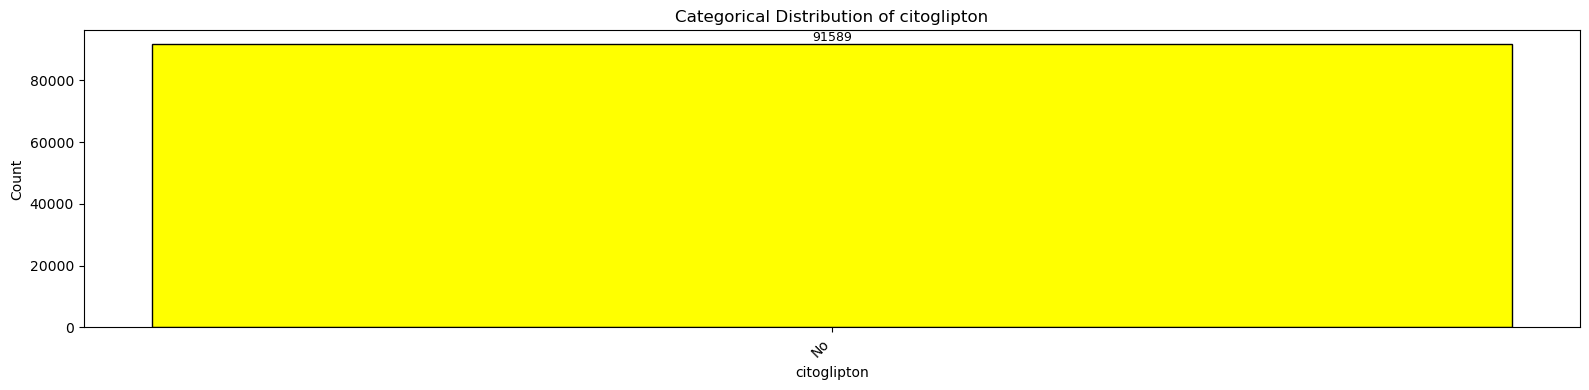

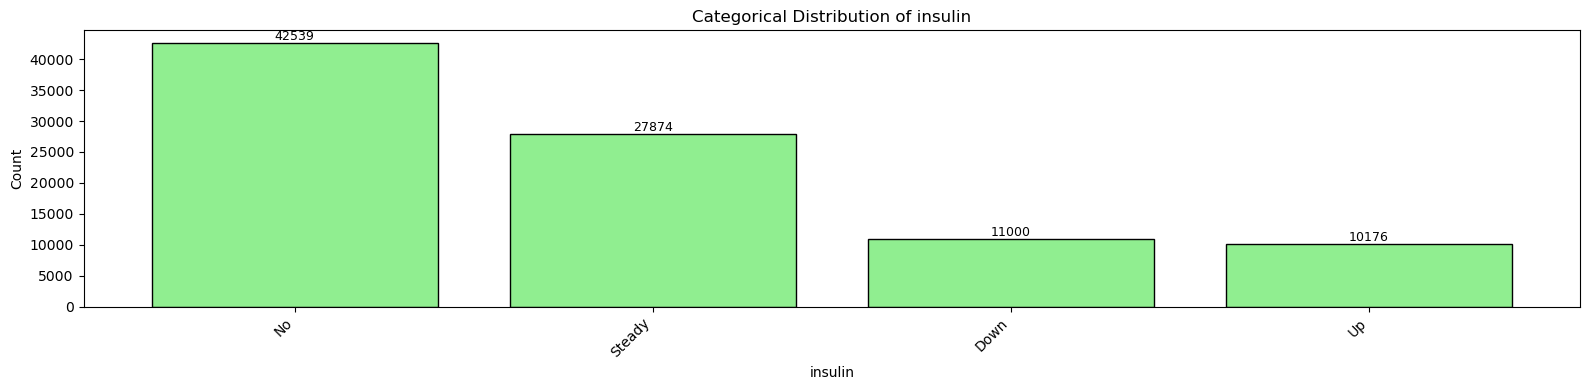

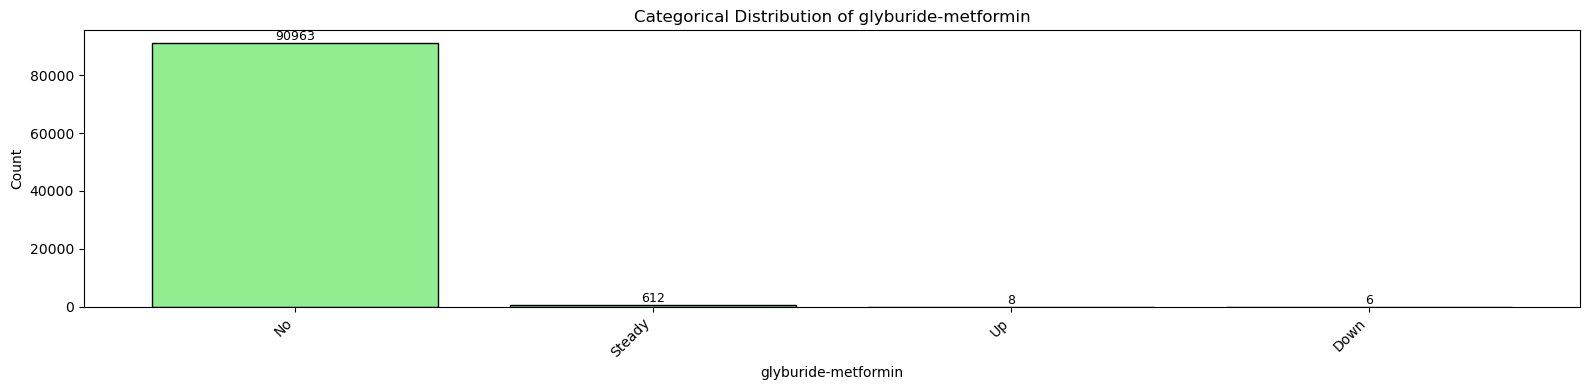

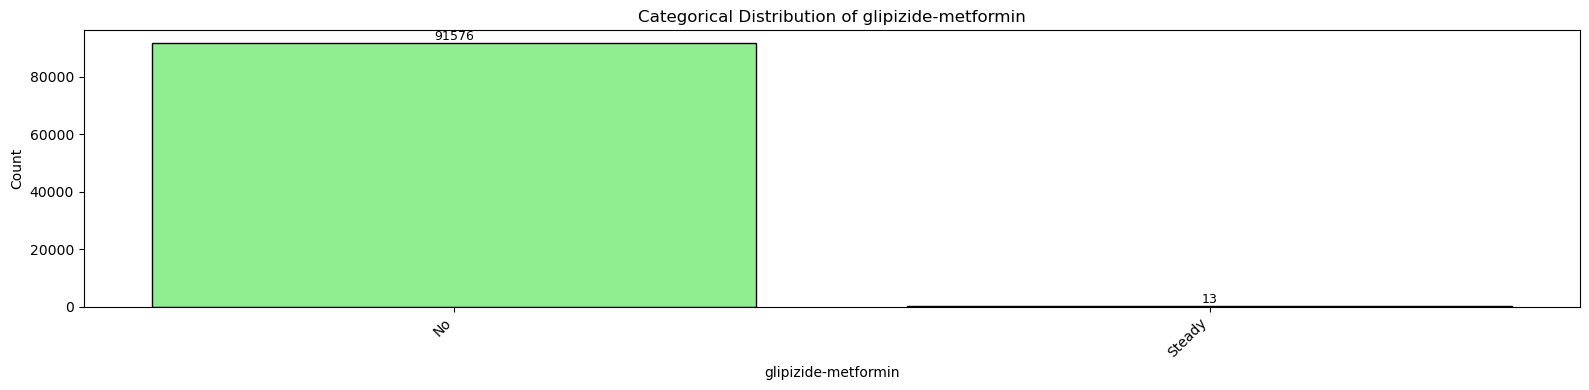

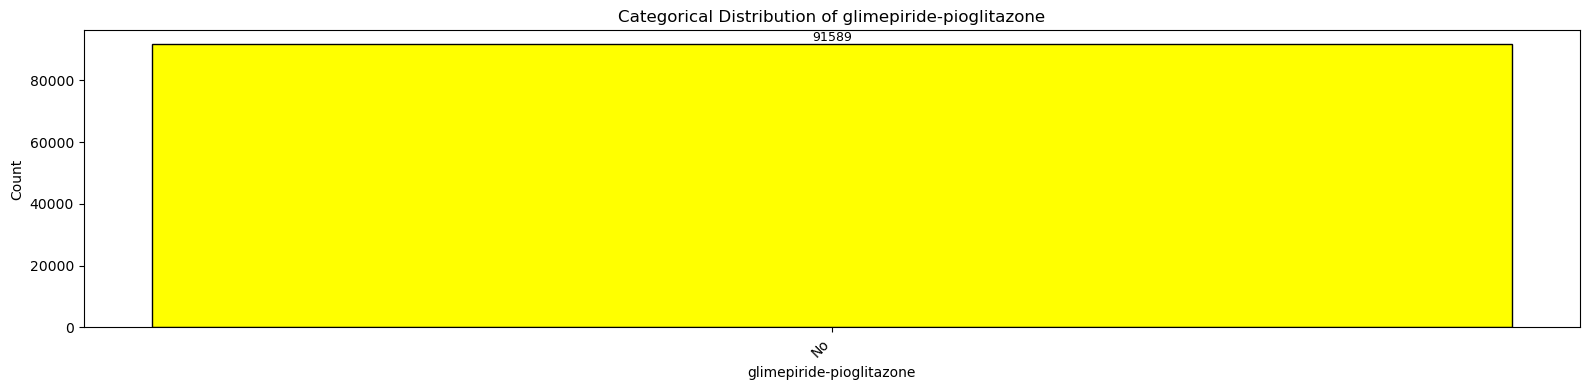

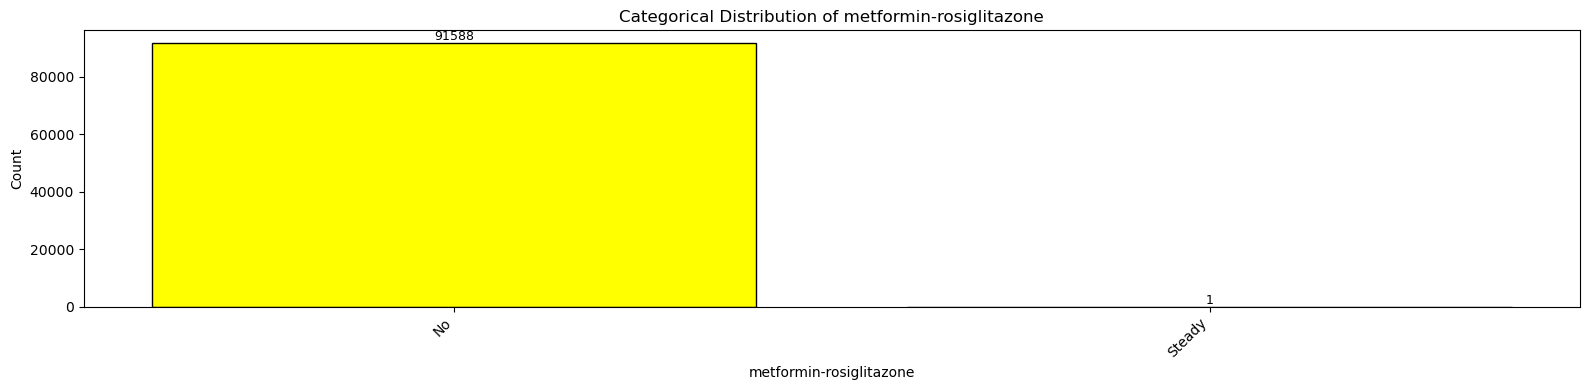

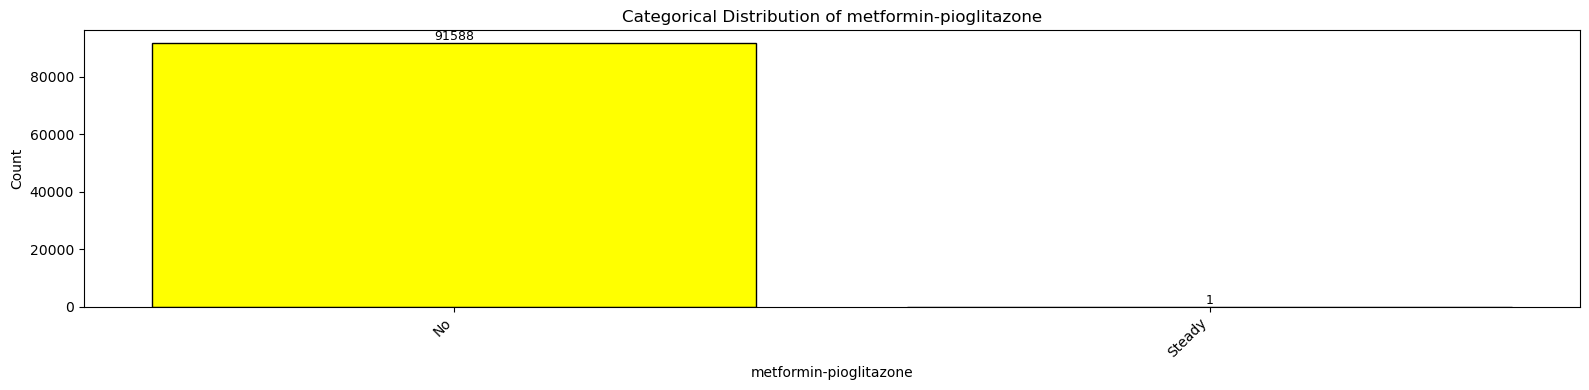

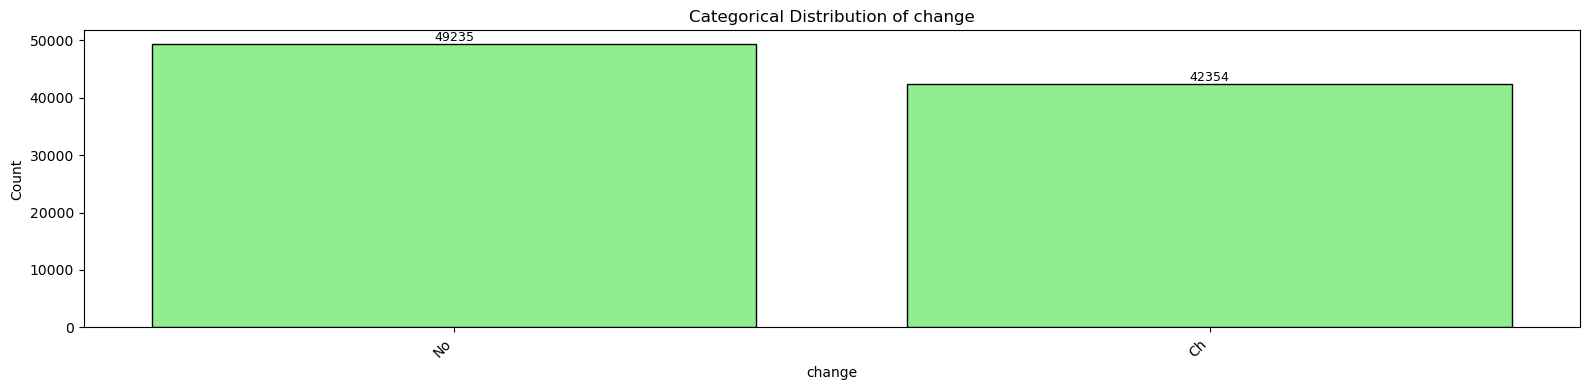

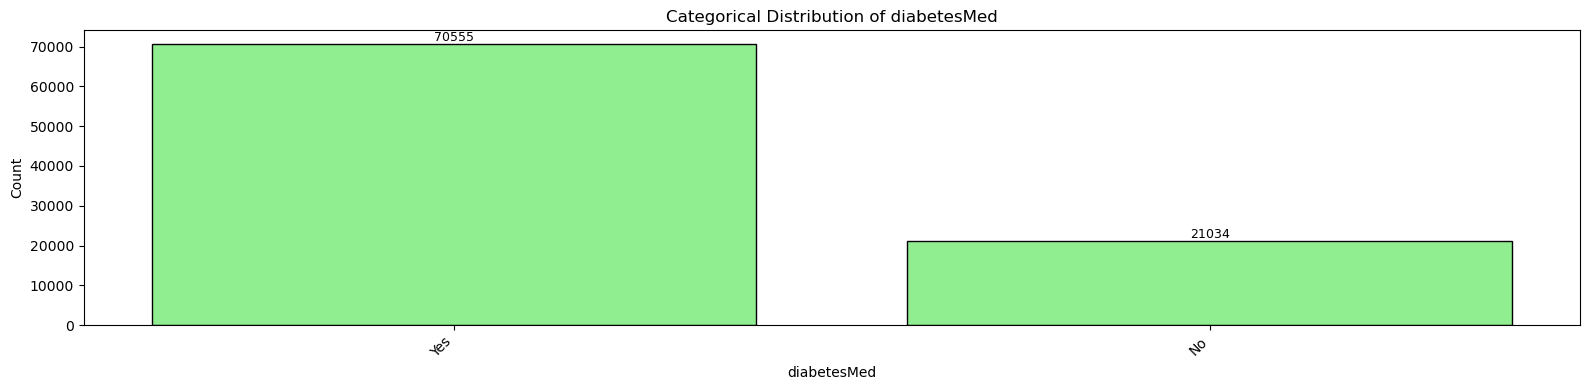

In [2]:
# ========= 固定路径（同目录）=========
DIR   = os.path.abspath(os.curdir) + "\\Dataset"  # 数据根目录
CSV_IN  = os.path.join(DIR,'diabetic_data_training.csv') # 原始文件

category_cols = ["race", "gender", "age", "weight", "admission_type_id", "discharge_disposition_id", 
                    "admission_source_id", "payer_code", "medical_specialty", "diag_1", "diag_2", "diag_3", 
                    "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                    "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", 
                    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone", "change", 
                    "diabetesMed", "readmitted"]


missing_cols = ["race", "weight", "payer_code", "medical_specialty", "diag_1", "diag_2", "diag_3"]

weak_cols = ["acetohexamide", "troglitazone", "examide", "citoglipton", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

df = pd.read_csv(CSV_IN)


for col in df.columns:
    if col in ["readmitted", "encounter_id", "patient_nbr"]:# 跳过无关标签
        continue  

    if col in category_cols:# 将分类特征强制作为字符串识别，避免误将数字形式的分类特征理解为连续值
        df[col] = df[col].astype(str)
    

    #总之这部分会绘制直方图然后在数据条上方显示各类型数据数目
    plt.figure(figsize=(16, 4))
    counts = df[col].value_counts()
    if col not in missing_cols:
        if col in weak_cols:
            bars = plt.bar(counts.index, counts.values, color='yellow', edgecolor='black')
        else:
            # 无缺失数据用淡绿色柱形图标注
            bars = plt.bar(counts.index, counts.values, color='lightgreen', edgecolor='black')
    else:
        
        # 有缺失数据用红色柱形图标注
        bars = plt.bar(counts.index, counts.values, color='red', edgecolor='black')
        
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, 
                 f'{int(height)}', ha='center', va='bottom', fontsize=9)
    if col in category_cols:
        plt.title(f"Categorical Distribution of {col}")
    else:
        plt.title(f"Numeral Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Basic Data Preprocessing

qwerty

In [3]:
# ========= 固定路径（同目录）=========
DIR   = os.path.abspath(os.curdir) + "\\Dataset"
TRAIN_IN  = os.path.join(DIR,'diabetic_data_training.csv')          # 原始训练数据
TRAIN_OUT = os.path.join(DIR,'diabetic_data_preprocessed.csv')      # 预处理后训练数据
TEST_IN = os.path.join(DIR,'diabetic_data_test.csv')                # 原始测试数据
TEST_OUT = os.path.join(DIR,'diabetic_data_test_preprocessed.csv')  # 预处理后测试数据
NPZ_OUT = os.path.join(DIR,'diabetes_preprocessed.npz')          # X / y, 仅作预处理后的训练数据
# ===================================


def preprocess(df):
    # 对数据进行预处理

    ### 该部分有待进一步调整 ###

    # 数据中的问号替换为NaN
    df.replace("?", np.nan, inplace=True)
    
    # 去除未知性别数据
    df = df[df["gender"] != "Unknown/Invalid"].copy()
    
    # 去除无关数据（病人ID等）和严重缺失数据
    df.drop(columns=["weight", "medical_specialty", "payer_code", "encounter_id", "patient_nbr"], inplace=True)
    
    # 填补少量缺失的数据
    df["race"].fillna("Unknown", inplace=True)
    # df["diag_1"].fillna("Unknown", inplace=True)
    # df["diag_2"].fillna("Unknown", inplace=True)
    df["diag_3"].fillna("Unknown", inplace=True)

    # 对readmitted（目标标签）进行三分类
    if "readmitted" in df.columns:
        df["readmitted"] = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2}).astype(np.int64)

    return df


def main():
    category_cols = ["race", "gender", "age", "weight", "admission_type_id", "discharge_disposition_id", 
                    "admission_source_id", "payer_code", "medical_specialty", "diag_1", "diag_2", "diag_3", 
                    "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                    "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", 
                    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone", "change", 
                    "diabetesMed"]
    
    # 读取原始训练数据
    df = pd.read_csv(TRAIN_IN)

    # 基本预处理
    df = preprocess(df)


    # one hot code the category type
    all_cols = df.columns
    category_cols = [col for col in all_cols if col in category_cols]

    cat_cols = category_cols
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    print("\n✅ 训练数据One-Hot编码完成")
    df.to_csv(TRAIN_OUT, index=False)

    # 拆分 X / y
    y = df["readmitted"].to_numpy(dtype=np.int64)
    X = df.drop(columns=["readmitted"]).to_numpy(dtype=np.float32)

    # 保存仅预处理后训练数据
    np.savez(NPZ_OUT, X=X, y=y)
    
    # 读取并预处理测试集
    df_test = pd.read_csv(TEST_IN)
    df_test = preprocess(df_test)

    df_test = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)
    print("\n✅ 训练数据One-Hot编码完成")
    # 确保测试集与训练集列对齐
    df_test = df_test.reindex(columns=df.columns, fill_value=0)
    df_test.to_csv(TEST_OUT, index=False)
    # 完成提示
    print("\n✅ 训练集、测试集预处理完成")

if __name__ == "__main__":
    main()


C:\Users\程远\AppData\Local\Temp\ipykernel_10128\1886618313.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["race"].fillna("Unknown", inplace=True)
C:\Users\程远\AppData\Local\Temp\ipykernel_10128\1886618313.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when


✅ 训练数据One-Hot编码完成


C:\Users\程远\AppData\Local\Temp\ipykernel_10128\1886618313.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["race"].fillna("Unknown", inplace=True)
C:\Users\程远\AppData\Local\Temp\ipykernel_10128\1886618313.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when


✅ 训练数据One-Hot编码完成

✅ 训练集、测试集预处理完成


## PCA (but only on data features) for Denoising Training Data

qwerty

In [4]:
DIR   = os.path.abspath(os.curdir) + "\\Dataset"
CSV_IN = os.path.join(DIR,'diabetic_data_preprocessed.csv') 
NPZ_OUT = os.path.join(DIR,'diabetes_with_pca.npz')

def main():
    df = pd.read_csv(CSV_IN) # 读取需要做降维的训练数据

    # 手动指定分类特征
    category_cols = ["race", "gender", "age", "weight", "admission_type_id", "discharge_disposition_id", 
                    "admission_source_id", "payer_code", "medical_specialty", "diag_1", "diag_2", "diag_3", 
                    "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                    "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", 
                    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone", "change", 
                    "diabetesMed", "readmitted"]

    # 计算数值特征集合和真正的分类特征集合
    # 分类特征集合需要再次计算，因为此时输入数据是预处理过的，可能已经失去了部分分类特征
    all_cols = df.columns
    num_cols = [col for col in all_cols if col not in category_cols]

    # 标准化数值特征
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(df[num_cols])

    # PCA 降噪 初步测试在保持87%~93%方差时效果最好
    pca = PCA(n_components=0.93, random_state=42)
    X_final = pca.inverse_transform(pca.fit_transform(X_num_scaled))
    
    y = df["readmitted"].to_numpy(dtype=np.int64)

    # 结果保存为 npz 文件：
    np.savez(NPZ_OUT, X=X_final, y = y)
    print("✅ PCA 降维 + 分类拼接完成")

if __name__ == "__main__":
    main()

✅ PCA 降维 + 分类拼接完成


## Basic Model Training (yet simply LR)

qwerty

In [5]:
# ---------- 固定文件名 ----------
DIR   = os.path.abspath(os.curdir) + "\\Dataset"
TRAIN_NPZ = os.path.join(DIR,'diabetes_with_pca.npz') # 预处理并PCA处理的训练数据
# TRAIN_NPZ = os.path.join(DIR,'diabetes_preprocessed.npz') # 仅做预处理（而没做PCA的）训练数据
TEST_CSV  = os.path.join(DIR,'diabetic_data_test_preprocessed.csv') # 预处理过的测试数据
# ---------------------------------


def main():
    
    # 读取训练数据
    data = np.load(TRAIN_NPZ)
    X_train, y_train = data["X"].astype(np.float32), data["y"].astype(np.int64)

    # 读取测试数据
    df_test = pd.read_csv(TEST_CSV)
    
    if "readmitted" not in df_test.columns:
        raise ValueError("测试集缺少 'readmitted' 标签列，无法评估准确率")

    y_test = df_test["readmitted"].to_numpy(dtype=np.int64)
    X_test = df_test.drop(columns=["readmitted"]).to_numpy(dtype=np.float32)

    if X_test.shape[1] != X_train.shape[1]:
        raise ValueError(f"特征维度不一致：train {X_train.shape[1]}, test {X_test.shape[1]}")

    # 3. 计算 Z-score 参数并正则化
    mean = X_train.mean(axis=0, keepdims=True)
    std  = X_train.std(axis=0, keepdims=True) + 1e-8
    X_train = (X_train - mean) / std

    
    mean = X_test.mean(axis=0, keepdims=True)
    std  = X_test.std(axis=0, keepdims=True) + 1e-8
    X_test = (X_test - mean) / std
    

    # 6. 划分验证集
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
    )



    # ---------- 训练模型 ----------
    print("开始训练 Logistic Regression 模型...")

    model = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
    # model = GaussianNB()  # 如果你想使用朴素贝叶斯，请改用这一行

    model.fit(X_train, y_train)

    # ---------- 验证集评估 ----------
    val_preds = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")

    # ---------- 测试集评估 ----------
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

if __name__ == "__main__":
    main()


开始训练 Logistic Regression 模型...


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Validation Accuracy: 58.11%
✅ Test Accuracy: 58.34%
